# Using accelerometer data to identify activities

This notebook has been adapated from [Charles Franzen](http://charlesfranzen.com/posts/predicting-activities-from-accelerometer-data/). In his work, he used this [data set](http://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer#), which consists of discrete samples of accelerometer data during various types of activities. 

The following code gives an example how to use supervised learning for the classification of activities on time series data. It uses scikit-learn, scipy, numpy, and pandas as the core technologies of this analysis.


If you're new to the iPython notebook, you can learn [more here](http://opentechschool.github.io/python-data-intro/core/notebook.html)
<!-- TEASER_END -->


## Overview

The task is to identify the wearers of activity given a sample of accelerometer data. The general approach that I took was that of Casale and Radeva in their [paper](https://www.researchgate.net/publication/221258784_Human_Activity_Recognition_from_Accelerometer_Data_Using_at_Wearable_Device?ev=prf_pub). It has been adapted to the dataset we are collecting in the HUNT4 study.

In [45]:
# import libraries for matrix manipulation and data visualization

%matplotlib inline
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from pandas import HDFStore,DataFrame



The data set comes from synchronized and labelled data obtained from Axivity sensors. 

In [70]:
# import data
store = HDFStore('/Users/kerstin/Documents/research/HUNT/hunt4training.h5')
print store
data = store['originial_data']

## use only one subject
data = data[data["subject"] == '009']
data.head()

<class 'pandas.io.pytables.HDFStore'>
File path: /Users/kerstin/Documents/research/HUNT/hunt4training.h5
/originial_data                       frame_table  (typ->appendable,nrows->10901356,ncols->8,indexers->[index],dc->[x_back,y_back,z_back,x_thigh,y_thigh,z_thigh,label,subject])
/originial_data_textlabels            frame_table  (typ->appendable,nrows->10901356,ncols->8,indexers->[index],dc->[x_back,y_back,z_back,x_thigh,y_thigh,z_thigh,label,subject])


,x_back,y_back,z_back,x_thigh,y_thigh,z_thigh,label,subject
0,-1.001465,-0.140625,0.171875,-0.989990,-0.049072,-0.279785,6,009
1,-1.000000,-0.140625,0.171875,-1.003418,-0.048096,-0.287842,6,009
2,-1.000000,-0.140625,0.170410,-0.997070,-0.041504,-0.293945,6,009
3,-1.000000,-0.140625,0.155273,-0.972168,-0.027832,-0.277832,6,009
4,-1.000000,-0.140625,0.156250,-0.947510,-0.036621,-0.285645,6,009


## Exploratory Analysis

In [71]:
# filter data; remove subject id for the further processing
data = data[['x_back' ,'y_back' ,'z_back', 'x_thigh' ,'y_thigh' ,'z_thigh', 'label']]

In [72]:
# renaming columns
data.columns = ['x_back' ,'y_back' ,'z_back', 'x_thigh' ,'y_thigh' ,'z_thigh', 'target']
#data.columns = ['x_back' ,'y_back' ,'z_back', 'target']
data.describe()

,x_back,y_back,z_back,x_thigh,y_thigh,z_thigh,target
count,310185.000000,310185.000000,310185.000000,310185.000000,310185.000000,310185.000000,310185.000000
mean,-0.944251,-0.055900,0.312873,-0.957228,0.095314,0.310347,12.302793
std,0.203294,0.172042,0.167103,0.658533,0.327879,0.851809,2.721524
min,-8.000000,-3.192139,-2.020752,-8.000000,-8.000000,-7.363770,1.000000
25%,-1.040527,-0.145508,0.221680,-1.407227,-0.093018,-0.273682,13.000000
50%,-0.953125,-0.052246,0.300049,-1.033203,0.083008,0.197021,13.000000
75%,-0.844482,0.038086,0.389160,-0.618652,0.291016,0.814209,13.000000
max,3.203857,3.057129,6.838135,4.279541,6.152832,7.999756,17.000000


In [73]:
# calculate and add norms for each data point
data['m'] = np.sqrt(data['x_back']**2 + data['y_back']**2 + data['z_back']**2 + data['x_thigh']**2 + data['y_thigh']**2 + data['z_thigh']**2)
#data['m'] = np.sqrt(data['x_back']**2 + data['y_back']**2 + data['z_back']**2)

### Descriptive statistics

In [74]:
# check for missing data
nan_flag = False
for c in data.columns:
    if any(data[c] == np.nan):
        print c, 'contains NaNs'
        nan_flag = True
if not nan_flag:
    print 'No missing values.'

No missing values.


In [75]:
# examine class distribution
data['target'].value_counts()/float(len(data))

13    0.841279
14    0.071222
6     0.039206
1     0.036598
5     0.003611
17    0.003095
4     0.002889
3     0.001148
12    0.000916
15    0.000039
Name: target, dtype: float64

### Visualizing the series

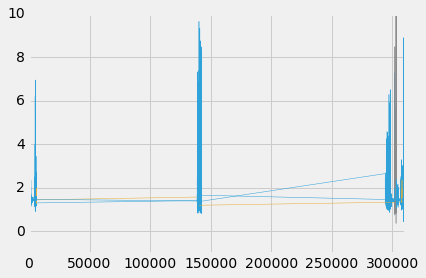

In [76]:
plt.style.use('fivethirtyeight')

for c in range(1, 8):
    plt.plot(data[data['target'] == c]['m'], linewidth=.5)
plt.xlim(0, len(data))
plt.ylim(-1, 10)
plt.ticklabel_format(style='sci', axis='y_thigh', scilimits=(0,0))

This gives an idea of the shape of the signal. It's clear that there are large differences between the different activities.

## Preprocessing

As recommended in the paper cited above, I generated two new time series from each of the original series plus the norms by applying digital filters. For each series I applied a high and low pass filter, with the cutoff set to 2hz, resulting in 12 total series.

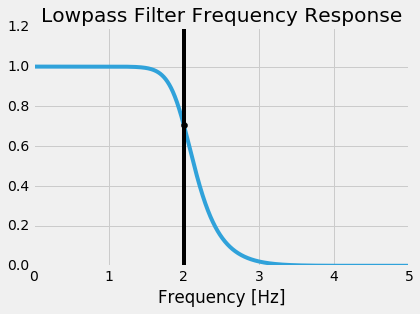

In [77]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    # helper function to return coefficients for scipy.lfilter
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    # applies a lowpass filter
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    # helper function to return coefficients for scipy.lfilter
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    # applies a highpass filter
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 10.       # sample rate, Hz
cutoff = 2.     # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.plot(0.5*fs*w/np.pi, np.abs(h))
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 5)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')

(2500, 2650)

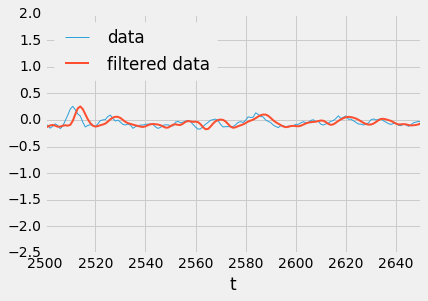

In [78]:
# test the filter on a sample of the dataset
filter_test_data = data[data['target'] == 13]['y_back']
filter_test_x = xrange(len(filter_test_data))
filter_test_y = butter_lowpass_filter(filter_test_data, cutoff, fs, order)
plt.plot(filter_test_x, filter_test_data, linewidth=1, label='data')
plt.plot(filter_test_x, filter_test_y, linewidth=2, label='filtered data')
plt.xlabel('t')
plt.legend(loc='upper left')
plt.xlim(0, len(filter_test_data))
#plt.ylim(1900, 2300)
plt.xlim(2500, 2650)

The filter should describe the signal of the raw data well.

In [79]:
# apply the filters
for c in ['x_back' ,'y_back' ,'z_back', 'x_thigh' ,'y_thigh' ,'z_thigh', 'm']:
#for c in ['x_back' ,'y_back' ,'z_back', 'm']:
    data[c+'l'] = butter_lowpass_filter(data[c], cutoff, fs, order)
    data[c+'h'] = butter_highpass_filter(data[c], cutoff, fs, order)

## Feature Extraction

I extracted features by windowing the series, creating 250 windows, each of a quarter second of data. Windows overlap adjacent windows, sharing 50% of its data with each. 
The following features are extracted from each window, for each time-series: 
 - root mean square value (RMS)
 - mean of the minmax sums
 - mean,  
 - standard deviation. 
This results in a dataset with 84 features for 6 incoming raw signals.

### RMS

This is calculated by taking the square root of the average of the squares of the series.

### Minmax sums

This is calculated by finding the differences between each min and max in the series, then averaging these values.

In [80]:
from scipy.signal import argrelmin, argrelmax

def rms(series):
    # returns root mean square value of a series
    return np.sqrt((series**2).mean())


def min_max_mean(series):
    # returns the average of the differences between local mins/maxs
    mins = argrelmin(series)[0]    # indices of the local minima
    maxs = argrelmax(series)[0]    # local maxima
    min_max_sum = 0
    # build the sums, then take the average
    if len(mins) <= len(maxs):
        for j, arg in enumerate(mins):
            min_max_sum += series[maxs[j]] - series[arg]
    else:
        for j, arg in enumerate(maxs):
            min_max_sum += series[arg] - series[mins[j]]
    return min_max_sum/float(min(len(mins), len(maxs)))


def extract_features(data, y, num_windows):
    window_len = len(data)/(num_windows/2)
    print 'window_len: ', window_len
    num_windows = len(data)/window_len
    print 'num_windows: ', num_windows
    i = 0    # initialize index

    print 'before: ', len(data)
    data = data[:window_len*num_windows-1]
    y = y[:window_len*num_windows]
    print 'after: ', len(data)
    
    features = []
    targets = []
    
    for n in range(num_windows):
        # isolate window
        win = data[i:i+window_len]
        
        # extract target
        target = int(y[i:i+window_len].mode())
        targets.append(target)
        
        for c in data.columns:
            # extract features for each series
            s = np.array(win[c])
            rms_val = rms(s)
            min_max = min_max_mean(s)
            mean = s.mean()
            std = s.std()
            new_features = [rms_val, min_max, mean, std]
            features.append(new_features)
        # update index
        i += window_len/2
    features = np.array(features)
    features.shape = num_windows, 84 #xyz --> 48; b+t xyz --> 84
    targets = np.array(targets)
    return features, targets

In [97]:
#features = data.drop(['sample', 'target'], axis=1)
features = data.drop(['target'], axis=1)
targets = data['target']

num_windows = 2100
X, y = extract_features(features, targets, num_windows)

print 'features:', X.size #features 702 * 48
print 'targets', y.size

window_len:  295
num_windows:  1051
before:  310185
after:  310044
features: 88284
targets 1051


In [98]:
#create target label lists


#column_names_num = sorted(data['target'].unique())
#column_names_text = column_names_num.replace({'target': no_to_label_dict})
#print column_names_num

#print features.info()
#print targets.size
#print features.size / targets.size

## Model building and evaluation

The null classifier predicts the majority class for every data point. I used this as a starting point.

In [99]:
from sklearn.cross_validation import train_test_split, cross_val_score

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=1)

In [100]:
# majority class prediction
from collections import Counter

label_counts = Counter(y_test)
null = label_counts.most_common()[0][1]/float(len(y_test))
print null

0.848341232227


In [101]:
import sklearn.metrics as met
    
# helper function to quickly build different models
def model_build(model):
    model.fit(X_train, y_train)
    return model

# helper function to handle evaluation
def model_eval(model):
    pred = model.predict(X_test)
    print 'Accuracy:\n-----------------------------'
    print met.accuracy_score(y_test, pred)
    print '\nConfusion Matrix:\n-----------------------------'
    print met.confusion_matrix(y_test, pred)
    print '\nClassification Report:\n-----------------------------'
    print met.classification_report(y_test, pred)
   

## Evaluation Results

In [102]:
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = model_build(KNeighborsClassifier())
model_eval(knn)

Accuracy:
-----------------------------
0.9336492891

Confusion Matrix:
-----------------------------
[[  7   0   0   0   0]
 [  4   0   0   0   0]
 [  0   0   5   0   0]
 [  0   0   0 178   1]
 [  1   0   0   8   7]]

Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1       0.58      1.00      0.74         7
          4       0.00      0.00      0.00         4
          6       1.00      1.00      1.00         5
         13       0.96      0.99      0.98       179
         14       0.88      0.44      0.58        16

avg / total       0.92      0.93      0.92       211



In [103]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rfc = model_build(RandomForestClassifier(n_estimators=20))
model_eval(rfc)

Accuracy:
-----------------------------
0.952606635071

Confusion Matrix:
-----------------------------
[[  6   0   0   0   1]
 [  3   1   0   0   0]
 [  0   0   5   0   0]
 [  0   0   0 176   3]
 [  1   0   0   2  13]]

Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1       0.60      0.86      0.71         7
          4       1.00      0.25      0.40         4
          6       1.00      1.00      1.00         5
         13       0.99      0.98      0.99       179
         14       0.76      0.81      0.79        16

avg / total       0.96      0.95      0.95       211



In [104]:
# Blending the models by voting
from sklearn.ensemble import VotingClassifier

vote = model_build(VotingClassifier(estimators=[('rf', rfc), ('knn', knn)]))
model_eval(vote)

Accuracy:
-----------------------------
0.9336492891

Confusion Matrix:
-----------------------------
[[  7   0   0   0   0]
 [  4   0   0   0   0]
 [  0   0   5   0   0]
 [  0   0   0 178   1]
 [  1   0   0   8   7]]

Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1       0.58      1.00      0.74         7
          4       0.00      0.00      0.00         4
          6       1.00      1.00      1.00         5
         13       0.96      0.99      0.98       179
         14       0.88      0.44      0.58        16

avg / total       0.92      0.93      0.92       211



In [105]:
# Random Forest with weighted classes

rfc_bal = model_build(RandomForestClassifier(n_estimators=50, class_weight='balanced'))
model_eval(rfc_bal)

Accuracy:
-----------------------------
0.947867298578

Confusion Matrix:
-----------------------------
[[  6   0   0   1   0]
 [  4   0   0   0   0]
 [  0   0   5   0   0]
 [  0   0   0 178   1]
 [  0   0   0   5  11]]

Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1       0.60      0.86      0.71         7
          4       0.00      0.00      0.00         4
          6       1.00      1.00      1.00         5
         13       0.97      0.99      0.98       179
         14       0.92      0.69      0.79        16

avg / total       0.93      0.95      0.94       211

